# Pryngles module: body 

## External modules

In [1]:
#@external
from pryngles import *

import spiceypy as spy
import numpy as np
from copy import deepcopy
from anytree import NodeMixin,RenderTree
#@end:external

## Constants

In [2]:
#@consts:body
BODY_KINDS=[]
#@end:consts

## The body class

The Body class is one of the most important classes in the package. 

In [3]:
#@docstring:Body
Body_doc=\
"""A general body.  This class is not intended to be used independently, just for inheritance purposes.
    
Initialization attributes:

    kind : string:
        One of the kind of bodies defined in the package (see _BODY_KINDS)
        Defined objects are: "Star", "Planet", "Ring".

    defaults : OrderedDict:
        Dictionary with the properties of the object.

    parent: Class Body:
        Object in the center of the orbit of this body.

    **properties: dicitionary:
        Specification of the body properties.  All objects of the class Body has the following
        properties by default:
        
        name: string, default = None:
            Name of the object, ie. a unique string identifying the object.  It can be provided
            by the user or automatically set by the initializer using a unique hash 
            (see hash Python function).

        orbital properties: 
            Object with the orbital properties of the body (eg. orbit.m is the mass)
            see each specific Body definition for attributes.
            orbit must be compatible with rebound.

                m: float [rebound mass units], default = 1:
                    Mass of the body.  If m = 0 the body does not produce gravitation.

        physical properties:

            Object with the physical properties of the body (eg. physics.radius)
            see each specific Body definition for attributes.

                radius: float [rebound length units], default = 1:
                    Radius of the body.

                prot: float [ut], default = 1:
                    Period of rotation of the star.

                i: float [rad], default = 0:
                    Inclination of the body equator with respect to the ecliptic plane.

                roll: float [rad], default = 0:
                    Roll angle.  This is the angle with respect to ecliptic x-axis in which 
                    the normal to the object equatorial plane is rotated.

                alpha_equ: float [rad], default = 0:
                    Longitude of the zero meridian of the object.

                q0: float [ut], default = 0:
                    Initial longitude for zero meridian.

        optical properties:

            Object with the optical properties of the body (eg. physics.lamb_albedo)
            see each specific Body definition for attributes.

                nspangles: int, default = 1000:
                    Number of spangles on which the object will be discretized.
                    
                spangle_type: int, default = SOLID_SPANGLE:
                    Type of spangles of the body.
                    
                preset: boolean, default = True:
                    If True spangle object from a preset.

Derived attributes:

        wrot: float [rad/ut]:
            Rotational angular velocity.

        n_equ: array(3):
            Rotational axis vector in the ecliptic system.
    
Secondary attributes:

    childs: list
        List with child bodies (bodies which have this body) as the center.

Public methods:

    update_body(**props):
        Update a given set of properties.
        
Examples:

    Create a body with None parent and name = 'B':
    
        B=Body("Body",BODY_DEFAULTS,None,name='B',m=2,c=2)
        
    Create a body having parent the Body "B" defined before:
         
        C=Body("Body",BODY_DEFAULTS,B,name="C")
"""
#@end:docstring

In [60]:
#@consts:body
"""
These are the default attributes for any body.
"""
BODY_DEFAULTS=dict()
BODY_DEFAULTS.update(odict(
    
    name=None,
    name_by_kind=False,
    
    #Orbit
    m=1,

    #Physics
    radius=1,
    prot=1,
    i=0, #Inclination of the rotational axis
    roll=0,
    alpha=0, #Zero meridian
    q0=0,
    
    #Optics
    nspangles=1000,
    spangle_type=SPANGLE_SOLID_ROCK,
    shape="sphere",
    geometry_args=dict(),
    seed=0,
    preset=True,
    
    #Legacy
    primary=None,
    optics=dict(),
    orbit=dict(),
    physics=dict(),
))

BODY_KINDS=[]
#@end:consts

In [65]:
#@class
class Body(Orbody):
    
    def __init__(self,kind,defaults,parent,**props):

        #Kind, parent and child attributes
        self.kind=kind
        self.__defaults=defaults

        #Name of the object
        if 'name' in props:
            name=self.name=str(props["name"])
        elif 'name_by_kind' in props:
            name=self.name=self.kind
        else:
            name=self.name=str(hash(self))

        #Legacy
        if 'primary' in props:
            parent=props["primary"]
        if 'optics' in props:
            props.update(props["optics"])
        if 'orbit' in props:
            props.update(props["orbit"])
        if 'physics' in props:
            props.update(props["physics"])

        #Update childs and parent
        if parent is not None:
            if not isinstance(parent,Body):
                raise AssertionError(f"Parent is not a valid Object: {type(parent)}, {isinstance(parent,Body)}")
            else:
                self.parent=parent
                parent._update_childs(self)

        #Update parent and childs        
        self._update_parent(parent)
        self._update_childs()

        #Update default properties
        self.__dict__.update(defaults)
        #Set name
        self.name=name
        #Update body
        self.update_body(**props)
    
    def update_body(self,**props):
        """Update properties of the Body.
        
        Parametes:
            **props: dictionary:
                Properties to update. The current object is updated with new 
                values provided in this new object
                
        Example:
            B.update_body(m=2)
                This only update the attribute m of orbit.
        """
        for prop in props:
            if prop in self.__defaults or prop in REBOUND_ORBITAL_PROPERTIES:
                self.__dict__[prop]=props[prop]
            else:
                raise ValueError(f"Property {prop} not identified in object {self.kind}")
                
        self.elements={k:v for k,v in self.__dict__.items() if k in REBOUND_ORBITAL_PROPERTIES}
        
        verbose(VERB_VERIFY,"Updating Body")
        self._update_properties()
    
    def _update_childs(self,child=None):
        if 'childs' not in self.__dict__:
            self.childs=dict()
        if child is not None:
            verbose(VERB_VERIFY,f"Add child {child.name} to body {self.kind} ({self.name})")
            self.childs[child.name]=child
            
    def _update_parent(self,parent=None):
        if 'parent' not in self.__dict__:
            if parent:
                verbose(VERB_VERIFY,f"Add parent {parent.name} to body {self.kind} ({self.name})")
            self.parent=parent
        elif parent is not None:
            verbose(VERB_VERIFY,f"Add parent {parent.name} to body {self.kind} ({self.name})")
            self.parent=parent
            parent._update_childs(self)
    
    def _update_properties(self):
        verbose(VERB_VERIFY,"Updating properties of Body")
        #Rotational angular velocity
        self.wrot=2*np.pi/self.prot
        #Rotation axis
        self.n_equ=sci.cartesian([1,self.roll,90*Consts.deg-self.i])
    
    def show_tree(self):
        print(RenderTree(self))
        
#@end:class
Body.__doc__=Body_doc

## Testing

In [66]:
#@test:body
def test_fun(self):

    global B,C
    Verbose.VERBOSITY=VERB_ALL

    B=Body("Body",BODY_DEFAULTS,None,m=2,x=2,a=1,name_by_kind=True)

    print(B)
    print(B.m)

    B.update_body(name="B")
    print(B)

    C=Body("Body",BODY_DEFAULTS,B,name="C")
    print(C)
    print(B)

    #Tree structure
    C.show_tree()
    B.show_tree()
    
    #Test legacy
    B=Body("Body",BODY_DEFAULTS,None,name_by_kind=True,primary=C,orbit=dict(m=2,x=2,a=1))
    print(B.m)

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass
Test.test_fun=test_fun
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

.

      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
{'kind': 'Body', 'name': 'Body', 'childs': {}, 'name_by_kind': True, 'm': 2, 'radius': 1, 'prot': 1, 'i': 0, 'roll': 0, 'alpha': 0, 'q0': 0, 'nspangles': 1000, 'spangle_type': 0, 'shape': 'sphere', 'geometry_args': {}, 'seed': 0, 'preset': True, 'primary': None, 'optics': {}, 'orbit': {}, 'physics': {}, 'x': 2, 'a': 1, 'elements': {'m': 2, 'x': 2, 'a': 1}, 'wrot': 6.283185307179586, 'n_equ': array([6.123234e-17, 0.000000e+00, 1.000000e+00])}
2
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
{'kind': 'Body', 'name': 'B', 'childs': {}, 'name_by_kind': True, 'm': 2, 'radius': 1, 'prot': 1, 'i': 0, 'roll': 0, 'alpha': 0, 'q0': 0, 'nspangles': 1000, 'spangle_type': 0, 'shape': 'sphere', 'geometry_args': {}, 'seed': 0, 'preset': True, 'primary': None, 'optics': {}, 'orbit': {}, 'physics': {}, 'x': 2, 'a': 1, 'elements': {'m': 2, 'x': 2,


----------------------------------------------------------------------
Ran 1 test in 0.128s

OK


In [29]:
#@method:Body
def spangle_body(self):
    """
    Spangle the surface of the body
    """
    
    #Create spangler
    self.sg=Spangler(
        nspangles=self.nspangles,
        name=self.name,
        n_equ=self.n_equ,
        alpha_equ=self.alpha,
        w=self.wrot,
        q0=self.q0,
    )
    
    #Populate spangler
    self.sg.populate_spangler(
        shape=self.shape,
        spangle_type=self.spangle_type,
        scale=self.radius,
        seed=self.seed,
        preset=self.preset,
        **self.geometry_args,
    )

    self.sg.set_observer()
    self.sg.set_luz()
#@end:method

Body.spangle_body=spangle_body

      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::set_positions:: Setting positions
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [6.123234e-17 0.000000e+00 1.000000e+00]
      VERB3::rotation_matrix:: Rotation axis: [0. 1. 0.] [-1.000000e+00  0.000000e+00  6.123234e-17] [6.123234e-17 0.000000e+00 1.000000e+00]
      VERB3::set_positions:: Converting to equatorial
      VERB3::set_positions:: Setting local matrix based on ex: 1000
      VERB3::populate_spangler:: Populating spangler from preset for sphere
  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
    VERB2::__init__:: Reading preset data from /Users/jorgezuluagacallejas/Dropbox/MiInvestigacion/PapersEnProceso/Exorings/pryngles/src/pryngles/data/sampler_presets/sample_sphere_N_100

<IPython.core.display.Javascript object>


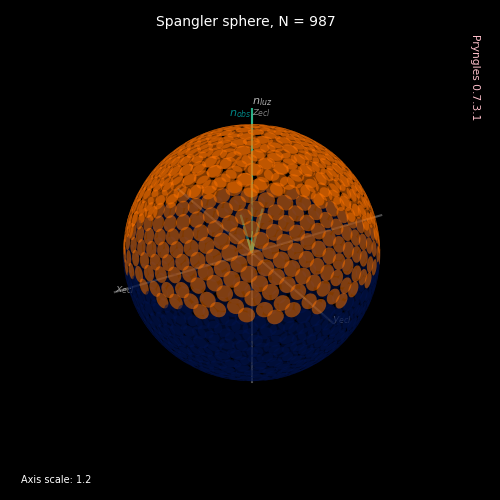

.
----------------------------------------------------------------------
Ran 1 test in 0.934s

OK


In [30]:
#@test:body
def test_spangle(self):

    Verbose.VERBOSITY=VERB_ALL

    #Create body
    B=Body("Body",BODY_DEFAULTS,None,name='B',m=2,x=2)
    B.spangle_body()
    B.sg.plot3d()

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass
Test.test_spangle=test_spangle
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

## Star Class

In [31]:
#@consts:body
"""
These are the default attributes for bodies of the kind 'Star'.
"""
STAR_DEFAULTS=deepcopy(BODY_DEFAULTS)
STAR_DEFAULTS.update(odict(

    #Orbit: update
    #Same as body
    
    #Physics: update
    #Same as Body
    
    #Optical properties: update
    limb_coeffs=[],
    spangle_type=SPANGLE_STELLAR,
    shape="sphere",
))
BODY_KINDS+=["Star"]
#@end:consts

In [32]:
#@class
class Star(Body):
    """A star.

    Initialization attributes:
        
        parent: Class Body, default = None:
            Object in the center of the orbit of the star for specification purposes.

            If None the object is the center of the orbit specification for other objects.
            
            Object parent for a star should be another star.
        
        **props: dictionary:
            List of properties for star.  For the complete set of default values of the properties
            see STAR_DEFAULTS.  Description of properties are available in the Body class documentation.
            
            Additional properties:
            
                limb_coeffs: list [adimensional], default = []:
                    List of limb darkening fit coefficients.  See Science.calc_limbdarkening.

                    Models in: https://pages.jh.edu/~dsing3/David_Sing/Limb_Darkening.html
                    Coefficients available at: https://pages.jh.edu/~dsing3/LDfiles/LDCs.CoRot.Table1.txt
                    
                spangle_type: int, default = STAR_SPANGLE:
                    Type of spangles

    Derived attributes:
    
    Methods:
    
        update_body(**pars):

            This method compute some derived attributes like.

    Notes:

        See Body class documentation.
    
    """
    def __init__(self,
                 parent=None,
                 **props
                ):
        
        
        #Instantiate object with basic properties
        Body.__init__(self,"Star",STAR_DEFAULTS,parent,**props)

        #Check parent
        if self.parent is not None:
            if self.parent.kind!="Star":
                raise ValueError(f"Only another Star can be the parent of a Star (you provided {self.parent.kind})")

        self._update_star_properties()
        
    def _update_star_properties(self):
        """Update specific properties of the star
        
        Properties to update:
        
            norm_limb_darkening: float:
                Limb darkening function normalization.
                Requires: limb_coefs.

        """
        verbose(VERB_VERIFY,"Updating properties of Star")

        #Compute limbdarkening at r = 0 to initialize normalization constant
        sci.limb_darkening(0,self.limb_coeffs)
        
        #Store limb darkening normalization
        self.norm_limb_darkening=SCIENCE_LIMB_NORMALIZATIONS[hash(tuple(self.limb_coeffs))]
        
    def update_star(self,**props):
        """General update propeties of the Star
        """
        verbose(VERB_VERIFY,"Updating star")
        
        Body.update_body(self,**props)
        self._update_star_properties()
#@end:class

      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_star_properties:: Updating properties of Star
{'kind': 'Star', 'name': '8774043500234', 'childs': {}, 'name_by_kind': False, 'm': 1, 'radius': 1, 'prot': 1, 'i': 0, 'roll': 0, 'alpha': 0, 'q0': 0, 'nspangles': 1000, 'spangle_type': 6, 'shape': 'sphere', 'geometry_args': {}, 'seed': 0, 'preset': True, 'optics': {}, 'orbit': {}, 'physics': {}, 'limb_coeffs': [], 'elements': {'m': 1}, 'wrot': 6.283185307179586, 'n_equ': array([6.123234e-17, 0.000000e+00, 1.000000e+00]), 'norm_limb_darkening': 3.141592653589793}
      VERB3::update_star:: Updating star
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_star_properties:: Updating properties of Star
{'kind': 'Star', 'name': '8774043500234', 'childs': {}, 'name_by_kind': False, 'm': 2, 'radius': 1, 'prot': 1, 'i': 0, 'roll': 0, 'alpha': 0, 'q0': 0, 

,name,spangle_type,geometry,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,wx_ecl,wy_ecl,ns_ecl,center_int,x_int,y_int,z_int,ns_int,rho_int,az_int,cosf_int,cos_int,azim_int,n_int,n_int_ecl,d_int,asp_int,z_cen_int,hidden_by_int,transit_over_int,string_int,center_obs,x_obs,y_obs,z_obs,ns_obs,rho_obs,az_obs,cosf_obs,cos_obs,azim_obs,n_obs,d_obs,asp_obs,z_cen_obs,hidden_by_obs,transit_over_obs,center_luz,x_luz,y_luz,z_luz,ns_luz,rho_luz,az_luz,cosf_luz,cos_luz,azim_luz,n_luz,d_luz,asp_luz,z_cen_luz,hidden_by_luz,transit_over_luz,azim_obs_luz,asp,dsp,albedo_gray_normal,albedo_gray_spherical,tau_gray_optical,Teq,Tem,emmisivity,unset,hidden,source,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
283,8774043551293,6,1,1,"[0.7071067811865476, 0.0, 0.7071067811865475]",0,6.283185,0,"[0, 0, 0]",0.173663,-0.170121,0.970000,1.0,5.508088,1.325231,"[0.17366274780164015, -0.17012128034429888, 0.9700000000000002]","[0, 0, 0]",0.806187,0.173663,0.565600,"[0.5529167721325072, 0.11910510557314885, -0.8246799481744286]","[-0.21058199388268456, 0.9775761984890963, 0.0]","[0.8061874887065428, 0.17366274780164015, 0.5655996667953597]","[0.0, 0.0, 0.0]",0.806187,0.173663,0.565600,"[0.8061874887065428, 0.17366274780164015, 0.5655996667953597]",0.824680,0.212170,0.565600,0.565600,3.141593,"[0, 0, 1]","[0.0, 0.0, 1.0]",inf,1.0,-inf,,,,"[0.0, 0.0, 0.0]",0.806187,0.173663,0.565600,"[0.8061874887065428, 0.17366274780164015, 0.5655996667953597]",0.824680,0.212170,0.565600,0.565600,3.141593,"[0, 0, 1]",inf,1.0,-inf,,,"[0.0, 0.0, 0.0]",0.806187,0.173663,0.565600,"[0.8061874887065428, 0.17366274780164015, 0.5655996667953597]",0.824680,0.212170,0.565600,0.565600,3.141593,"[0, 0, 1]",inf,1.0,-inf,,,0,0.043633,0.235702,1.0,1.0,0.0,273.15,273.15,1,False,False,False,True,False,False,False,False,False,True,False,False,False
284,8774043551293,6,1,1,"[0.7071067811865476, 0.0, 0.7071067811865475]",0,6.283185,0,"[0, 0, 0]",-0.011606,0.214447,0.976667,1.0,1.624866,1.354349,"[-0.01160642023720628, 0.21444699399035494, 0.9766666666666668]","[0, 0, 0]",0.538971,-0.011606,0.842245,"[0.8420493269923155, -0.018133042041365968, -0.5390956535700457]","[0.021529426476257493, 0.9997682150356668, -0.0]","[0.5389706993032108, -0.01160642023720628, 0.8422445466145123]","[0.0, 0.0, 0.0]",0.538971,-0.011606,0.842245,"[0.5389706993032108, -0.01160642023720628, 0.8422445466145123]",0.539096,6.261654,0.842245,0.842245,3.141593,"[0, 0, 1]","[0.0, 0.0, 1.0]",inf,1.0,-inf,,,,"[0.0, 0.0, 0.0]",0.538971,-0.011606,0.842245,"[0.5389706993032108, -0.01160642023720628, 0.8422445466145123]",0.539096,6.261654,0.842245,0.842245,3.141593,"[0, 0, 1]",inf,1.0,-inf,,,"[0.0, 0.0, 0.0]",0.538971,-0.011606,0.842245,"[0.5389706993032108, -0.01160642023720628, 0.8422445466145123]",0.539096,6.261654,0.842245,0.842245,3.141593,"[0, 0, 1]",inf,1.0,-inf,,,0,0.043633,0.235702,1.0,1.0,0.0,273.15,273.15,1,False,False,False,True,False,False,False,False,False,True,False,False,False
285,8774043551293,6,1,1,"[0.7071067811865476, 0.0, 0.7071067811865475]",0,6.283185,0,"[0, 0, 0]",-0.115387,-0.140504,0.983333,1.0,4.024829,1.387968,"[-0.11538747573594085, -0.14050368678025163, 0.9833333333333334]","[0, 0, 0]",0.794673,-0.115387,0.595971,"[0.5897856444976678, -0.08563760913796571, -0.8030062848107751]","[0.14369436194777904, 0.9896221149228733, -0.0]","[0.7946727778707984, -0.11538747573594085, 0.5959705584627452]","[0.0, 0.0, 0.0]",0.794673,-0.115387,0.595971,"[0.7946727778707984, -0.11538747573594085, 0.5959705584627452]",0.803006,6.138992,0.595971,0.595971,3.141593,"[0, 0, 1]","[0.0, 0.0, 1.0]",inf,1.0,-inf,,,,"[0.0, 0.0, 0.0]",0.794673,-0.115387,0.595971,"[0.7946727778707984, -0.11538747573594085, 0.5959705584627452]",0.803006,6.138992,0.595971,0.595971,3.141593,"[0, 0, 1]",inf,1.0,-inf,,,"[0.0, 0.0, 0.0]",0.794673,-0.115387,0.595971,"[0.7946727778707984, -0.11538747573594085, 0.5959705584627452]",0.803006,6.138992,0.595971,0.5

  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect using nvec = [0, 0, 1], alpha = 0 center = None, name = None
      VERB3::set_intersect:: Generating intersection matrices from pvec = [0, 0, 1]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect using nvec = [0, 0, 1], alpha = 0 center = None, name = None
      VERB3::set_intersect:: Generating intersection matrices from pvec = [0, 0, 1]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::set_luz:: Number of points: 288


<IPython.core.display.Javascript object>


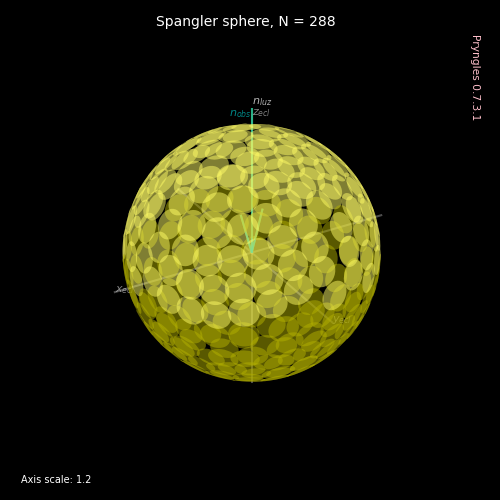

.
----------------------------------------------------------------------
Ran 1 test in 0.713s

OK


In [33]:
#@test:body
def test_star(self):

    global S
    Verbose.VERBOSITY=VERB_ALL

    S=Star()
    print(S)

    #Check derived properties
    self.assertEqual(np.isclose([S.wrot],
                                [2*np.pi/BODY_DEFAULTS["prot"]],
                                rtol=1e-7),
                     [True]*1)

    S.update_star(m=2,limb_coeffs=[1,1])
    print(S)

    #Check exception: parent could not be different from None or Body
    self.assertRaises(AssertionError,lambda:Star(parent="Nada"))     

    S=Star(nspangles=270,i=45*Consts.deg)
    S.spangle_body()

    print_df(S.sg.data.tail())

    S.sg.set_observer()
    S.sg.set_luz()
    S.sg.plot3d()

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass    
Test.test_star=test_star
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

## Planet class

In [34]:
#@consts:body
"""
These are the default attributes for bodies of the kind 'Planet'.
"""
PLANET_DEFAULTS=deepcopy(BODY_DEFAULTS)
PLANET_DEFAULTS.update(odict(
    
    #Orbit: update
    a=1,e=0,
    
    #Physics: update
    #Same as Body
    
    #Optical: update
    spangle_type=SPANGLE_SOLID_ROCK,
    geometry="sphere",
    
    albedo_gray_spherical=1,
))
BODY_KINDS+=["Planet"]
#@end:consts

In [35]:
#@class
class Planet(Body):
    """A planet.

    Initialization attributes:
        
        parent: Class Body, default = None:
            Object in the center of the orbit of the star for specification purposes.
            If None the object is the center of the orbit specification for other objects.

        **props: dictionary:
            List of properties for star.  For the complete set of default values of the properties
            see STAR_DEFAULTS.  Description of properties are available in the Body class documentation.
            
            Additional properties:
            
                x,y,z: float [ul], default = 1.0, 0.0, 0.0:
                    Initial position of the body.

                vy: float, default = 0.0, 1.0, 0.0:
                    Intitial velocity of the body
        
    Derived attributes:
        None.
    
    Notes:

        See Body class documentation.
    
    """
    
    def __init__(self,
                 parent=None,
                 **props
                ):
        
        
        #Instantiate object with basic properties
        Body.__init__(self,"Planet",PLANET_DEFAULTS,parent,**props)
        
        #Check parent
        if self.parent is None:
            raise ValueError(f"Parent not provided and it is mandatory for {self.kind}.")
        
        #Update properties
        self.update_planet(**props)

    def _update_planet_properties(self):
        """Update specific properties of the star
        
        Properties to update:
        
            norm_limb_darkening: float:
                Limb darkening function normalization.
                Requires: limb_coefs.

        """
        verbose(VERB_VERIFY,"Updating Planet properties")
        
    def update_planet(self,**pars):
        verbose(VERB_VERIFY,"Updating Planet")
        Body.update_body(self,**pars)
        self._update_planet_properties()
#@end:class

      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_star_properties:: Updating properties of Star
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_childs:: Add child 8774044102663 to body Star (8774057923392)
      VERB3::_update_parent:: Add parent 8774057923392 to body Planet (8774044102663)
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::update_planet:: Updating Planet
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_planet_properties:: Updating Planet properties
8774044102663
      VERB3::update_planet:: Updating Planet
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_planet_properties:: Updating Planet properties
{'kind': 

,name,spangle_type,geometry,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,wx_ecl,wy_ecl,ns_ecl,center_int,x_int,y_int,z_int,ns_int,rho_int,az_int,cosf_int,cos_int,azim_int,n_int,n_int_ecl,d_int,asp_int,z_cen_int,hidden_by_int,transit_over_int,string_int,center_obs,x_obs,y_obs,z_obs,ns_obs,rho_obs,az_obs,cosf_obs,cos_obs,azim_obs,n_obs,d_obs,asp_obs,z_cen_obs,hidden_by_obs,transit_over_obs,center_luz,x_luz,y_luz,z_luz,ns_luz,rho_luz,az_luz,cosf_luz,cos_luz,azim_luz,n_luz,d_luz,asp_luz,z_cen_luz,hidden_by_luz,transit_over_luz,azim_obs_luz,asp,dsp,albedo_gray_normal,albedo_gray_spherical,tau_gray_optical,Teq,Tem,emmisivity,unset,hidden,source,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
194,8774044102663,0,1,1,"[6.123233995736766e-17, 0.0, 1.0]",0,6.283185,0,"[0, 0, 0]",0.280805,-0.095518,0.955,1.0,5.955305,1.269660,"[0.28080478278493565, -0.09551792483667675, 0.9550000000000001]","[0, 0, 0]",0.095518,0.280805,0.955,"[0.3075449587526389, 0.9041244927253315, -0.29660579899927775]","[-0.946727217513436, 0.3220366060237056, 0.0]","[0.0955179248366768, 0.28080478278493565, 0.9550000000000001]","[0.0, 0.0, 0.0]",0.095518,0.280805,0.955,"[0.0955179248366768, 0.28080478278493565, 0.9550000000000001]",0.296606,1.242916,0.955,0.955,3.141593,"[0, 0, 1]","[0.0, 0.0, 1.0]",inf,1.0,-inf,,,,"[0.0, 0.0, 0.0]",0.095518,0.280805,0.955,"[0.0955179248366768, 0.28080478278493565, 0.9550000000000001]",0.296606,1.242916,0.955,0.955,3.141593,"[0, 0, 1]",inf,1.0,-inf,,,"[0.0, 0.0, 0.0]",0.095518,0.280805,0.955,"[0.0955179248366768, 0.28080478278493565, 0.9550000000000001]",0.296606,1.242916,0.955,0.955,3.141593,"[0, 0, 1]",inf,1.0,-inf,,,0,0.063148,0.283552,1.0,1.0,0.0,273.15,273.15,1,False,False,False,True,False,False,False,False,False,True,False,False,False
195,8774044102663,0,1,1,"[6.123233995736766e-17, 0.0, 1.0]",0,6.283185,0,"[0, 0, 0]",-0.126025,0.229984,0.965,1.0,2.072083,1.305443,"[-0.12602538251072315, 0.22998391892266234, 0.9650000000000001]","[0, 0, 0]",-0.229984,-0.126025,0.965,"[-0.8462710490104344, -0.46373517400212294, -0.26224988083886674]","[0.48055458445815846, -0.8769648176273931, 0.0]","[-0.2299839189226623, -0.12602538251072315, 0.9650000000000001]","[0.0, 0.0, 0.0]",-0.229984,-0.126025,0.965,"[-0.2299839189226623, -0.12602538251072315, 0.9650000000000001]",0.262250,3.642880,0.965,0.965,3.141593,"[0, 0, 1]","[0.0, 0.0, 1.0]",inf,1.0,-inf,,,,"[0.0, 0.0, 0.0]",-0.229984,-0.126025,0.965,"[-0.2299839189226623, -0.12602538251072315, 0.9650000000000001]",0.262250,3.642880,0.965,0.965,3.141593,"[0, 0, 1]",inf,1.0,-inf,,,"[0.0, 0.0, 0.0]",-0.229984,-0.126025,0.965,"[-0.2299839189226623, -0.12602538251072315, 0.9650000000000001]",0.262250,3.642880,0.965,0.965,3.141593,"[0, 0, 1]",inf,1.0,-inf,,,0,0.063148,0.283552,1.0,1.0,0.0,273.15,273.15,1,False,False,False,True,False,False,False,False,False,True,False,False,False
196,8774044102663,0,1,1,"[6.123233995736766e-17, 0.0, 1.0]",0,6.283185,0,"[0, 0, 0]",-0.052893,-0.215818,0.975,1.0,4.472047,1.346721,"[-0.052892584597813236, -0.2158179197716515, 0.9750000000000001]","[0, 0, 0]",0.215818,-0.052893,0.975,"[0.9469751083186244, -0.2320843472208531, -0.22220486043288937]","[0.23803522791882367, 0.9712565213524352, -0.0]","[0.21581791977165155, -0.052892584597813236, 0.9750000000000001]","[0.0, 0.0, 0.0]",0.215818,-0.052893,0.975,"[0.21581791977165155, -0.052892584597813236, 0.9750000000000001]",0.222205,6.042843,0.975,0.975,3.141593,"[0, 0, 1]","[0.0, 0.0, 1.0]",inf,1.0,-inf,,,,"[0.0, 0.0, 0.0]",0.215818,-0.052893,0.975,"[0.21581791977165155, -0.052892584597813236, 0.9750000000000001]",0.222205,6.042843,0.975,0.975,3.141593,"[0, 0, 1]",inf,1.0,-inf,,,"[0.0, 0.0, 0.0]",0.215818,-0.052893,0.975,"[0.21581791977165155, -0.052892584597813236, 0.9750000000000001]",0.222205,6.042843,0.975,0.975,3.141593,"[0, 0, 1]",inf,1.0,-inf,,,0,0.063148,0.283552,1.0,1.0,0.0,273.15,273.15,1,False,False,False,True,False,Fa

<IPython.core.display.Javascript object>


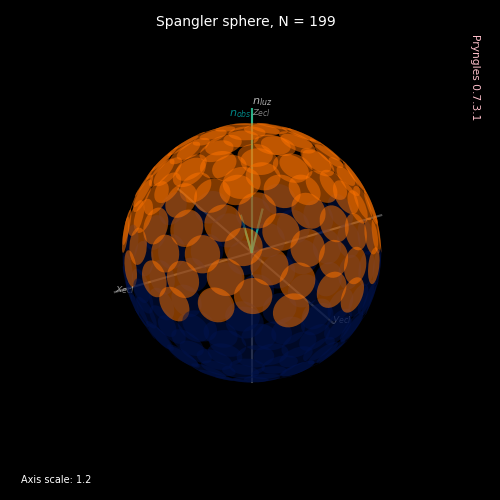

.
----------------------------------------------------------------------
Ran 1 test in 0.607s

OK


In [36]:
#@test:body
def test_planet(self):

    Verbose.VERBOSITY=VERB_ALL

    S=Star()

    #Check exception: parent is mandatory for planets
    self.assertRaises(ValueError,lambda:Planet())

    P=Planet(parent=S)
    print(P.name)

    #Check derived properties
    self.assertEqual(np.isclose([P.wrot],
                                [2*np.pi/BODY_DEFAULTS["prot"]],
                                rtol=1e-7),
                     [True]*1)

    #Check a non-existing property
    P.update_planet(vz=0.2)
    print(P)

    #Check exception: parent could not be different from None or Body
    self.assertRaises(AssertionError,lambda:Planet(parent="Nada"))

    P.update_body(nspangles=250)
    P.spangle_body()
    print_df(P.sg.data.tail())

    P.sg.plot3d()

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass    
Test.test_planet=test_planet
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

## Ring class

In [37]:
#@consts:body
RING_DEFAULTS=deepcopy(BODY_DEFAULTS)
RING_DEFAULTS.update(odict(

    #Orbit: update
    #Same as Body altough ring has not orbit properties
    
    #Physics: update
    #Same as Body
    fi=1.0,
    fe=2.0,
    
    #Optics: update
    spangle_type=SPANGLE_GRANULAR,
    shape="ring",
    albedo_gray_normal=1,
    tau_gray_optical=0,
))

BODY_KINDS+=["Ring"]
#@end:consts

## Ring Class

In [38]:
#@class
class Ring(Body):
    """Class Ring.
    
Initialization attributes:
        
        parent: Class Body, default = None:
            Object in the center of the orbit of the star for specification purposes.
            If None the object is the center of the orbit specification for other objects.

        **props: dictionary:
            List of properties for star.  For the complete set of default values of the properties
            see STAR_DEFAULTS.  Description of properties are available in the Body class documentation.
            
            Additional properties:

            fi: float [adimensional], default = 1:
                Fraction of the radius of the parent object where ring stars.

            fe: float [adimensional], default = 1:
                Fraction of the radius of the parent object where ring ends.

            albedo_gray_normal: float. default = 1: 
                Lambertian (normal) gray (wavelength indpendent) albedo of the spangle.

            tau_gray_optical: float. default = 0:
                Gray (wavelength indpendent) Optical depth of the spangle.  
                If 0 the spangle is entirely opaque to all wavelength, despite its type.            

    Derived attributes:
    
        ri: float:
            Radius of the inner border of the ring in units of the parent radius.

        re: float:
            Radius of the outer border of the ring in units of the parent radius.
            
    Notes:

        See Body class documentation.
    """
    def __init__(self,
                 parent=None,
                 **props
                ):
        
        
        #Instantiate object with basic properties
        Body.__init__(self,"Ring",RING_DEFAULTS,parent,**props)
        
        #Check parent
        if self.parent is None:
            raise ValueError(f"Parent not provided and mandatory for {self.kind}.")
        
        #Update properties
        self.update_ring(**props)

    def _update_ring_properties(self):
        """Update specific properties of the star
        
        Properties to update:
        
            ri, re: float:
                Radius of the inner (outer) border of the ring in units of the parent radius.
                Requires: limb_coefs.
                
            radius: float:
                Object radius.
                
            geometry_args: dictionary:
                
        """
        verbose(VERB_VERIFY,"Updating Ring properties")
    
        #Update radius
        self.ri=self.fi*self.parent.radius
        self.re=self.fe*self.parent.radius
        self.radius=self.re
        
        #Update geometry args for spangling purposes
        self.geometry_args=dict(ri=self.ri/self.re)
        
    def update_ring(self,**pars):
        verbose(VERB_VERIFY,"Updating Ring")
        Body.update_body(self,**pars)
        self._update_ring_properties()   

#@end:class

      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_star_properties:: Updating properties of Star
      VERB3::_update_childs:: Add child 8774057428923 to body Star (8774057428818)
      VERB3::_update_parent:: Add parent 8774057428818 to body Planet (8774057428923)
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::update_planet:: Updating Planet
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_planet_properties:: Updating Planet properties
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_childs:: Add child 8774057428911 to body Planet (8774057428923)
      VERB3::_update_parent:: Add parent 8774057428923 to body Ring (8774057428911)
      VERB3::update_body:: Updating Body
      VERB3::_update_properti

,name,spangle_type,geometry,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,wx_ecl,wy_ecl,ns_ecl,center_int,x_int,y_int,z_int,ns_int,rho_int,az_int,cosf_int,cos_int,azim_int,n_int,n_int_ecl,d_int,asp_int,z_cen_int,hidden_by_int,transit_over_int,string_int,center_obs,x_obs,y_obs,z_obs,ns_obs,rho_obs,az_obs,cosf_obs,cos_obs,azim_obs,n_obs,d_obs,asp_obs,z_cen_obs,hidden_by_obs,transit_over_obs,center_luz,x_luz,y_luz,z_luz,ns_luz,rho_luz,az_luz,cosf_luz,cos_luz,azim_luz,n_luz,d_luz,asp_luz,z_cen_luz,hidden_by_luz,transit_over_luz,azim_obs_luz,asp,dsp,albedo_gray_normal,albedo_gray_spherical,tau_gray_optical,Teq,Tem,emmisivity,unset,hidden,source,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
289,8774057428911,4,0,3,"[0.8660254037844386, 0.0, 0.5]",0,6.283185,0,"[0, 0, 0]",0.500000,-8.660254e-01,0.0,1.0,5.235988,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",4.330127e-01,0.500000,-7.500000e-01,"[0.5, 0.0, -0.8660254037844386]","[0.0, 1.0, 0.0]","[0.8660254037844386, 0.0, 0.5]","[0.0, 0.0, 0.0]",4.330127e-01,0.500000,-7.500000e-01,"[0.8660254037844386, 0.0, 0.5]",0.661438,0.857072,-7.500000e-01,0.5,3.141593,"[0, 0, 1]","[0.0, 0.0, 1.0]",inf,1.0,-inf,,,,"[0.0, 0.0, 0.0]",4.330127e-01,0.500000,-7.500000e-01,"[0.8660254037844386, 0.0, 0.5]",0.661438,0.857072,-7.500000e-01,0.5,3.141593,"[0, 0, 1]",inf,1.0,-inf,,,"[0.0, 0.0, 0.0]",4.330127e-01,0.500000,-7.500000e-01,"[0.8660254037844386, 0.0, 0.5]",0.661438,0.857072,-7.500000e-01,0.5,3.141593,"[0, 0, 1]",inf,1.0,-inf,,,0,0.09343,0.344904,1.0,1.0,0.0,273.15,273.15,1,False,True,False,False,False,False,False,False,False,False,False,False,False
290,8774057428911,4,0,3,"[0.8660254037844386, 0.0, 0.5]",0,6.283185,0,"[0, 0, 0]",0.707107,-7.071068e-01,0.0,1.0,5.497787,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",3.535534e-01,0.707107,-6.123724e-01,"[0.5, 0.0, -0.8660254037844386]","[0.0, 1.0, 0.0]","[0.8660254037844386, 0.0, 0.5]","[0.0, 0.0, 0.0]",3.535534e-01,0.707107,-6.123724e-01,"[0.8660254037844386, 0.0, 0.5]",0.790569,1.107149,-6.123724e-01,0.5,3.141593,"[0, 0, 1]","[0.0, 0.0, 1.0]",inf,1.0,-inf,,,,"[0.0, 0.0, 0.0]",3.535534e-01,0.707107,-6.123724e-01,"[0.8660254037844386, 0.0, 0.5]",0.790569,1.107149,-6.123724e-01,0.5,3.141593,"[0, 0, 1]",inf,1.0,-inf,,,"[0.0, 0.0, 0.0]",3.535534e-01,0.707107,-6.123724e-01,"[0.8660254037844386, 0.0, 0.5]",0.790569,1.107149,-6.123724e-01,0.5,3.141593,"[0, 0, 1]",inf,1.0,-inf,,,0,0.09343,0.344904,1.0,1.0,0.0,273.15,273.15,1,False,True,False,False,False,False,False,False,False,False,False,False,False
291,8774057428911,4,0,3,"[0.8660254037844386, 0.0, 0.5]",0,6.283185,0,"[0, 0, 0]",0.866025,-5.000000e-01,0.0,1.0,5.759587,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",2.500000e-01,0.866025,-4.330127e-01,"[0.5, 0.0, -0.8660254037844386]","[0.0, 1.0, 0.0]","[0.8660254037844386, 0.0, 0.5]","[0.0, 0.0, 0.0]",2.500000e-01,0.866025,-4.330127e-01,"[0.8660254037844386, 0.0, 0.5]",0.901388,1.289761,-4.330127e-01,0.5,3.141593,"[0, 0, 1]","[0.0, 0.0, 1.0]",inf,1.0,-inf,,,,"[0.0, 0.0, 0.0]",2.500000e-01,0.866025,-4.330127e-01,"[0.8660254037844386, 0.0, 0.5]",0.901388,1.289761,-4.330127e-01,0.5,3.141593,"[0, 0, 1]",inf,1.0,-inf,,,"[0.0, 0.0, 0.0]",2.500000e-01,0.866025,-4.330127e-01,"[0.8660254037844386, 0.0, 0.5]",0.901388,1.289761,-4.330127e-01,0.5,3.141593,"[0, 0, 1]",inf,1.0,-inf,,,0,0.09343,0.344904,1.0,1.0,0.0,273.15,273.15,1,False,True,False,False,False,False,False,False,False,False,False,False,False
292,8774057428911,4,0,3,"[0.8660254037844386, 0.0, 0.5]",0,6.283185,0,"[0, 0, 0]",0.965926,-2.588190e-01,0.0,1.0,6.021386,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",1.294095e-01,0.965926,-2.241439e-01,"[0.5, 0.0, -0.8660254037844386]","[0.0, 1.0, 0.0]","[0.8660254037844386, 0.0, 0.5]","[0.0, 0.0, 0.0]",1.294095e-01,0.965926,-2.241439e-01,"[0.8660254037844386, 0.0, 0.5]",0.974556,1.437615,-2.241439e-01,0.5,3.141593,"[0, 0, 1]","[0.0, 0.0, 1.0]",inf,1.0,-inf,,,,"[0.0, 0.0, 0.0]",1.294095e-01,0.965926,-2.241439e-01,"[0.866

<IPython.core.display.Javascript object>


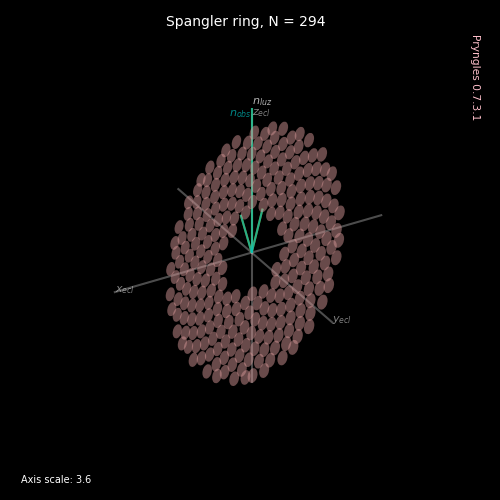

.
----------------------------------------------------------------------
Ran 1 test in 0.872s

OK


In [39]:
#@test:body
def test_ring(self):

    Verbose.VERBOSITY=VERB_ALL

    #Define first star and planet
    S=Star()
    P=Planet(parent=S)

    self.assertRaises(ValueError,lambda:Ring())
    R=Ring(parent=P)

    R.update_ring(fe=3)
    print(R)

    R.update_body(nspangles=250,i=60*Consts.deg,roll=0*Consts.deg)
    R.spangle_body()
    print_df(R.sg.data.tail())
    R.sg.plot3d()

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass    
Test.test_ring=test_ring
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

## Class Observer (legacy)

In [67]:
#@consts:body
OBSERVER_DEFAULTS=deepcopy(BODY_DEFAULTS)
OBSERVER_DEFAULTS.update(odict(
    lamb=0,
    beta=0,
))
BODY_KINDS+=["Observer"]
#@end:consts

#@class
class Observer(Body):
    """This class is intended only for legacy purposes.
    """
    def __init__(self,
                 parent=None,
                 **props
                ):
        Body.__init__(self,"Observer",OBSERVER_DEFAULTS,parent,**props)
#@end:class

### The end

In [ ]:
#@end:module

## Playing ground

In [ ]:
S1=Star(m=1)
P1S1=Planet(parent=S1,m=0.1,a=1,e=0.2)
M1P1=Planet(parent=P1S1,m=0.01,a=0.1,e=0.5)
SM1M1=Planet(parent=P1S1,m=0.0,a=0.01,e=0.2)

S2=Star(m=1,a=5,e=0.3)
P1S2=Planet(parent=S2,m=0.1,a=1,e=0.5)
#All possible systems
#Simple binary
"""
orbital_tree=[S1,S2]
#Star and planet with moon
orbital_tree=[S1,[P1S1,M1P1]]
#Star and planet with moon and minimoon
orbital_tree=[S1,[P1S1,[M1P1,SM1M1]]]
#Two stars with their planets
orbital_tree=[[S1,P1S1],[S2,P1S2]]
#Two stars with planets and moon
orbital_tree=[[S1,[P1S1,M1P1]],[S2,P1S2]]
""";
#Two stars with planets, moon and minimoon
orbital_tree=[[S1,[P1S1,[M1P1,SM1M1]]],[S2,P1S2]]

orbit,pelements=OrbitUtil.build_system(orbital_tree)
orbit.calculate_orbit()
Plot.animate_rebound(orbit.sim,color='b',ms=2)